In [2]:
import pathlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Resizing, Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model

In [5]:
# Path to your dataset
data_dir = pathlib.Path('../javaproject/fruits')

# Image dimensions
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3

# Define class labels
fruit_images_dict = {
    'apple': list(data_dir.glob('apple/*')),
    'banana': list(data_dir.glob('banana/*')),
    'cherry': list(data_dir.glob('cherry/*')),
    'grapes': list(data_dir.glob('grapes/*')),
    'kiwi': list(data_dir.glob('kiwi/*')),
    'mango': list(data_dir.glob('mango/*')),
    'orange': list(data_dir.glob('orange/*')),
    'strawberry': list(data_dir.glob('strawberry/*'))
}

# Labels from 0 to 7
fruit_labels_dict = {
    'apple': 0,
    'banana': 1,
    'cherry': 2,
    'grapes': 3,
    'kiwi': 4,
    'mango': 5,
    'orange': 6,
    'strawberry': 7
}

In [6]:
# Prepare the dataset
X, Y = [], []

for fruit_name, images in fruit_images_dict.items():
    for image_file_path in images:
        if image_file_path.name.startswith("."):
            continue
        with Image.open(image_file_path) as img:
            img = img.convert("RGB")
            if img.size[1] < IMAGE_HEIGHT or img.size[0] < IMAGE_WIDTH:
                continue
            img = img.resize([IMAGE_WIDTH, IMAGE_HEIGHT], Image.LANCZOS)
            img_data = np.array(img)/255
        X.append(img_data)
        Y.append(fruit_labels_dict[fruit_name])


X = np.array(X)
Y = np.array(Y)

# Convert labels to categorical (one-hot encoding)
Y = to_categorical(Y, num_classes=8)

# Split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [7]:
# Define the model architecture
model = Sequential([
    Input(shape=(None, None, IMAGE_CHANNELS)),

    Resizing(
        width=IMAGE_WIDTH,
        height=IMAGE_HEIGHT,
        interpolation="bilinear",
        crop_to_aspect_ratio=False,
        #pad_to_aspect_ratio=False,
    ),
    
    # Input Layer
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Layer
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Layer
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Flatten the output
    Flatten(),

    # Dense Layer
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output Layer
    Dense(8),
    Activation('softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, Y_train, batch_size=16)

# Train the model
history = model.fit(
    train_generator,
    validation_data=(X_test, Y_test),
    epochs=70,
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict the classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert Y_test from one-hot encoding to class labels
Y_test_classes = np.argmax(Y_test, axis=1)

class_report = classification_report(Y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

Epoch 1/70
14/14 [==============================] - 2s 136ms/step - loss: 2.5841 - accuracy: 0.1562 - val_loss: 2.2140 - val_accuracy: 0.0938
Epoch 2/70
14/14 [==============================] - 2s 130ms/step - loss: 2.0090 - accuracy: 0.3795 - val_loss: 2.4318 - val_accuracy: 0.0833
Epoch 3/70
14/14 [==============================] - 2s 130ms/step - loss: 1.7719 - accuracy: 0.3929 - val_loss: 2.6826 - val_accuracy: 0.0833
Epoch 4/70
14/14 [==============================] - 2s 140ms/step - loss: 1.5950 - accuracy: 0.4375 - val_loss: 2.9196 - val_accuracy: 0.0833
Epoch 5/70
14/14 [==============================] - 3s 187ms/step - loss: 1.7053 - accuracy: 0.4464 - val_loss: 3.0168 - val_accuracy: 0.0833
Epoch 6/70
14/14 [==============================] - 2s 150ms/step - loss: 1.4275 - accuracy: 0.4688 - val_loss: 3.2593 - val_accuracy: 0.0833
Epoch 7/70
14/14 [==============================] - 2s 157ms/step - loss: 1.4114 - accuracy: 0.4955 - val_loss: 3.4496 - val_accuracy: 0.0833
Epoch 

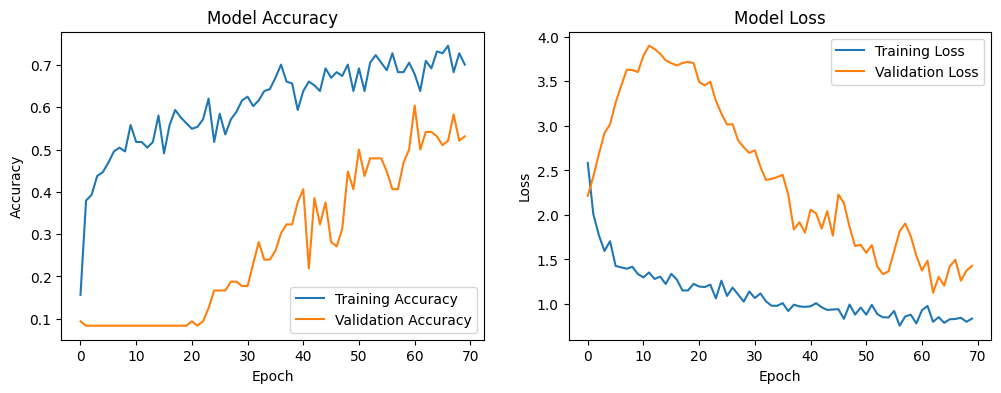

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [9]:
# Define classes
classes = {v:k for k,v in fruit_labels_dict.items()}
classes = [classes[i] for i in range(len(classes))]

3/3 [==============================] - 0s 57ms/step


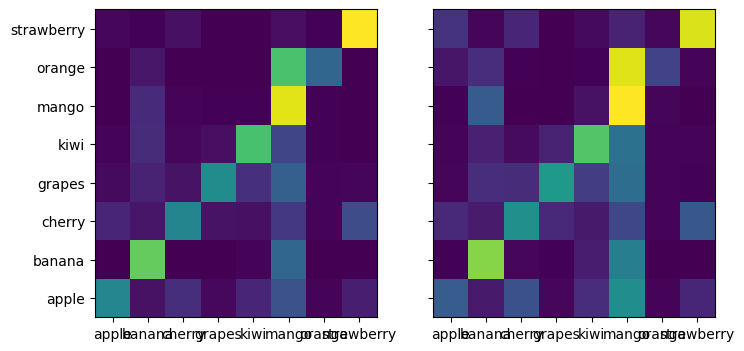

In [10]:
fig,axes = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,(X,Y) in zip(axes,[(X_train,Y_train),(X_test, Y_test)]):
    y_pred = model.predict(X)
    confusion = (y_pred[:,None,:]*Y[:,:,None]).sum(0)/Y.sum(0)[:,None]
    ax.pcolormesh(confusion)
    ax.set_xticks(np.r_[0.5:8],classes)
    ax.set_yticks(np.r_[0.5:8],classes)


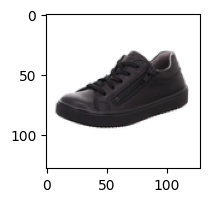

1/1 [==============================] - 0s 49ms/step
Predicted class: 1 name= banana
[[ 1 50  8  5 20 13  1  1]]


In [11]:
# Load and preprocess the image
fileImage = Image.open("../Test-Pictures/no-fruit.jpeg").convert("RGB").resize([IMAGE_WIDTH, IMAGE_HEIGHT], Image.LANCZOS)
image = np.array(fileImage)/255
myimage = image.reshape(1, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

# Display the image
plt.figure(figsize=(4, 2))
plt.imshow(myimage[0])
plt.show()

# Predict the class
my_prediction = model.predict(myimage)
predicted_class = np.argmax(my_prediction, axis=1)[0]

# Print the predicted class
print("Predicted class:", predicted_class, "name=", classes[predicted_class])
print(np.round(my_prediction*100).astype(int))

In [12]:
output_dir = pathlib.Path("models/fruitclassifier")
tf.saved_model.save(model, output_dir)

INFO:tensorflow:Assets written to: models/fruitclassifier/assets


INFO:tensorflow:Assets written to: models/fruitclassifier/assets


In [13]:
with open(output_dir/"synset.txt", "wt") as fh:
    for c in classes:
        fh.write(c+"\n")

In [14]:
with open(output_dir/"serving.properties","wt") as fh:
    fh.write("""
application=cv/image_classification
engine=TensorFlow
width=128
height=128
centerCrop=false
resize=true
applySoftmax=false
""")